# CSI 4142 Assignment 3: Dataset 1: Housing Prices

## Group Info:
**Group #:** 120

**<u>Group Members</u>**<br>
Aydin Yalcinkaya 300238613<br>
Mustafa Ahmed 300242013<br>

# Imports and Installations
Before getting started we must perform a few installations and library imports.

Run the following installations:

In [2]:
#imports
import pandas as pd
import os.path
from datetime import datetime
import re
import numpy as np
from IPython.display import display
from rapidfuzz import fuzz
from rapidfuzz import process
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

## Report Description

The purpose of this report is to practice a predictive analysis study. The primary methodology is using Lineaer Regression.

## Housing Prices Regression Dataset
Author: Den Kuznetz

Link to the dataset: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression

Dataset use-case: dataset prepared for creating a predictive model.

### How to download:
Run the following command in the same directory as the notebook:

In [3]:
! rm housing-prices-regression.zip real_estate_dataset.csv
! curl -L -o housing-prices-regression.zip\
  https://www.kaggle.com/api/v1/datasets/download/denkuznetz/housing-prices-regression\
    && unzip housing-prices-regression.zip
! rm housing-prices-regression.zip

rm: housing-prices-regression.zip: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24182  100 24182    0     0  29320      0 --:--:-- --:--:-- --:--:-- 29320
Archive:  housing-prices-regression.zip
  inflating: real_estate_dataset.csv  


### Initial data output command:

In [4]:
if not os.path.exists('real_estate_dataset.csv'):
    raise Exception('Please download and extract the dataset with the command above.')
house_df = pd.read_csv('real_estate_dataset.csv')
print(house_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    int64  
 7   Has_Pool            500 non-null    int64  
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB
None


In [5]:
house_df["Year_Built"].mean()

1957.604

# 1) Data Cleaning:
For our data cleaning we will perform the following cleaning checks followed by the relevant imputation/cleaning methods:

- Consistency
- Range
- Uniqueness
- Presence
- Exact Duplicates
- Near Duplicates

Due to the nature of this dataset being primarily numerical data and very minimal categorical data We will skip over the following cleaning steps as they pertain to more to categorical data: 

- Format
- Length
- Look-up

We will skip over Data Type check and cleaning as well since all the columns are strictly enforced as either int64 or float64 type which cannot be mixed up with any other data type:

- Data Type


## Consistency Check

We will check the following consistencies: 

- Garage_Size < Square_Feet
    - Pre-requisite step: convert Garage_Size from sqm to sqft

In [6]:
# Step 1: Convert Garage_Size from sqm to sqft
house_df["Garage_Size"] = house_df["Garage_Size"] * 10.7639

In [7]:
# Step 2: Consistency check: Garage_Size in sqft should be less than Square_Feet
invalid_garages = house_df[house_df["Garage_Size"] >= house_df["Square_Feet"]]

# Step 3: Display the rows that violate the condition
invalid_garages

ID  Square_Feet  Num_Bedrooms  Num_Bathrooms  Num_Floors  Year_Built  \
0      1   143.635030             1              3           3        1967   
1      2   287.678577             1              2           1        1949   
4      5    89.004660             4              3           3        1999   
5      6    88.998630             5              3           2        1959   
6      7    64.520903             4              3           1        1938   
..   ...          ...           ...            ...         ...         ...   
494  495   165.924601             4              3           1        1935   
495  496   138.338057             2              2           2        1967   
496  497   195.914028             2              3           1        1977   
497  498    69.433659             1              1           2        2004   
498  499   293.598702             5              1           3        1940   

     Has_Garden  Has_Pool  Garage_Size  Location_Score  Distance_to_Center  \
0             1         1     516.6672        8.297631            5.935734   
1             0         1     398.2643        6.061466           10.827392   
4             1         0     365.9726        1.523278           14.648277   
5             1         1     387.5004        8.994552           17.633250   
6             0         1     344.4448        7.101354            2.429908   
..          ...       ...          ...             ...                 ...   
494           1         1     236.8058        4.893764           15.889616   
495           1         0     172.2224        4.296086            5.562583   
496           0         1     484.3755        7.406261            2.845105   
497           0         0     193.7502        8.629724            6.263264   
498           1         0     441.3199        5.318891           16.990684   

             Price  
0    602134.816747  
1    591425.135386  
4    619879.142523  
5    670386.804433  
6    523827.125601  
..             ...  
494  622815.455423  
495  488496.350722  
496  657736.921717  
497  405324.950201  
498  773035.968028  

[409 rows x 12 columns]

### Inconsistencies found:
409 rows were found to have a larger garage than home. This seemed like a clear mixup as this makes up for approximately 82% of the dataset. Rows where the garage size is greater than the square feet of the home, these values will be swapped.

In [8]:
# Identify where Garage_Size is greater than Square_Feet
swap_condition = house_df["Garage_Size"] > house_df["Square_Feet"]

# Perform the swap PROPERLY
house_df.loc[swap_condition, ["Square_Feet", "Garage_Size"]] = (house_df.loc[swap_condition, ["Garage_Size", "Square_Feet"]].values)

Verify the swap was completed correctly. There should be no rows such that Square_Feet < Garage_Size.

Perform a check:

In [9]:
# Identify where Garage_Size is greater than Square_Feet
swap_condition =  house_df["Square_Feet"] < house_df["Garage_Size"]

# Display rows where the condition is True (Square_Feet < Garage_Size)
inconsistent_rows = house_df[swap_condition]

# Print the problematic rows
num_inconsistent = len(inconsistent_rows)

print(f"There are {num_inconsistent} rows such that Square_Feet < Garage_Size")
print("View some samples:")
inconsistent_rows

There are 0 rows such that Square_Feet < Garage_Size
View some samples:


Empty DataFrame
Columns: [ID, Square_Feet, Num_Bedrooms, Num_Bathrooms, Num_Floors, Year_Built, Has_Garden, Has_Pool, Garage_Size, Location_Score, Distance_to_Center, Price]
Index: []

## Range:

Given that majority of the values are int64 or float64, a range check is valuable.

### Perform the range check:

In [10]:
#Range Filters
min_sqft = 46.0
min_bed = 1
min_bath = 1
min_floors = 1
year_built_range = range(1600, 2025)
min_garage_size = 16.7225
location_score_range = (0,10)
min_dist_ctr = 0
min_price = 0

# Create a mask for valid rows
valid_mask = (
    (house_df["Square_Feet"] >= min_sqft) &
    (house_df["Num_Bedrooms"] >= min_bed) &
    (house_df["Num_Bathrooms"] >= min_bath) &
    (house_df["Num_Floors"] >= min_floors) &
    (house_df["Year_Built"].isin(year_built_range)) &
    (house_df["Garage_Size"] >= min_garage_size) &
    (house_df["Location_Score"].between(*location_score_range)) &
    (house_df["Distance_to_Center"] >= min_dist_ctr) &
    (house_df["Price"] >= min_price)
)

# Get the problematic rows
problematic_rows = house_df[~valid_mask]  # Invert mask to get failing rows

# Display the problematic rows (There should be none)
problematic_rows.head()

Empty DataFrame
Columns: [ID, Square_Feet, Num_Bedrooms, Num_Bathrooms, Num_Floors, Year_Built, Has_Garden, Has_Pool, Garage_Size, Location_Score, Distance_to_Center, Price]
Index: []

In [11]:
num_invalid_rows_range = len(problematic_rows["Garage_Size"])
invalid_garage_vals = problematic_rows["Garage_Size"].unique()

print(f"There are {num_invalid_rows_range} rows with invalid ranges")
print(f"Invalid garage values: {invalid_garage_vals}")

There are 0 rows with invalid ranges
Invalid garage values: []


#### Invalid Garage Sizes

By logic and my research, the minimum garage size is 10x8 feet or 16.7725 Square feet. We will imputate the minumum garage size to such records

In [12]:
#Convert the Garage_Size column to a float64 type
house_df["Garage_Size"] = house_df["Garage_Size"].astype(float)

In [13]:
# Impute the invalid garage sizes with the minimum size
house_df["Garage_Size"] = house_df["Garage_Size"].apply(lambda x: max(x, 16.7225))

#### Successful Garage_Size Imputation
There should be no more range errors upon the Garage_Size imputation

## Uniqueness Check:
Only the ID Column needs to have unique values so we will verify that by ensuring the number of unique id values is the same as the length of the entire dataset. This is becsause there is a 1 to 1 relationship between the ID and each row.

In [14]:
len(house_df['ID'].unique()) == len(house_df)

True

## Presence Check:
We will check for null values in each column. Upon performing the check there are in fact none.

In [15]:
print(house_df.isna().sum())

ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64


No Null values

## Duplicate Check

In [16]:
duplicates = house_df[house_df.duplicated()]

duplicates

Empty DataFrame
Columns: [ID, Square_Feet, Num_Bedrooms, Num_Bathrooms, Num_Floors, Year_Built, Has_Garden, Has_Pool, Garage_Size, Location_Score, Distance_to_Center, Price]
Index: []

No duplicates found

## Near Duplicate Check


In [17]:
house_df_rounded = house_df.copy()

# Round numerical columns to a specific number of decimal places
numeric_columns = ['Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']
house_df_rounded[numeric_columns] = house_df[numeric_columns].round(2)

# Now check for duplicates in the rounded dataset
near_duplicates = house_df_rounded[house_df_rounded.duplicated()]
near_duplicates

Empty DataFrame
Columns: [ID, Square_Feet, Num_Bedrooms, Num_Bathrooms, Num_Floors, Year_Built, Has_Garden, Has_Pool, Garage_Size, Location_Score, Distance_to_Center, Price]
Index: []

No near duplicates identified

# 2) Categorical Feature Encoding

There is already existing one-hot encoding in the Has_Garden and Has_Pool columns. All other columns are numerical therfore there can be no further categorical feature encoding.

# 3) EDA and Outlier Detection


In [18]:
#Collect all the columns, excluding those containing 'LOF_Score'
main_columns = [col for col in house_df.columns if 'LOF_Score' not in col and 'Outl' not in col]

### Identify the Outliers:

In [19]:
# Identify numerical columns (exclude 'ID' since it's just an identifier)
num_cols = house_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop("ID")  # Drop ID column

# Set LOF parameters
n_neighbors = 20
contamination = 0.05

# Run LOF for each numerical column
for col in num_cols:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(house_df[[col]])
    
    # Store results in a new column for each feature
    house_df[f"LOF_Score_{col}"] = lof.negative_outlier_factor_
    house_df[f"Is_Outlier_{col}"] = outliers == -1

# Combine all outlier flags (flagged in ANY column)
house_df["Is_Outlier_Any"] = house_df[[f"Is_Outlier_{col}" for col in num_cols]].any(axis=1)

### Visualize the outliers:

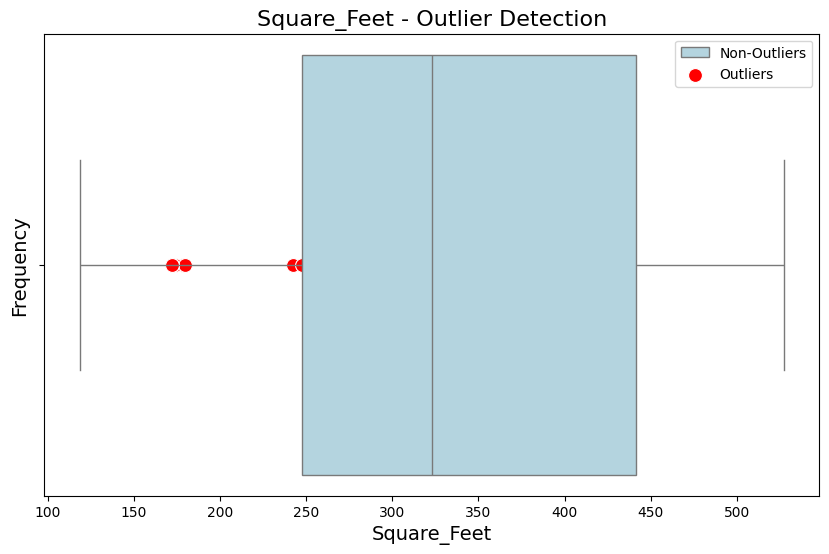

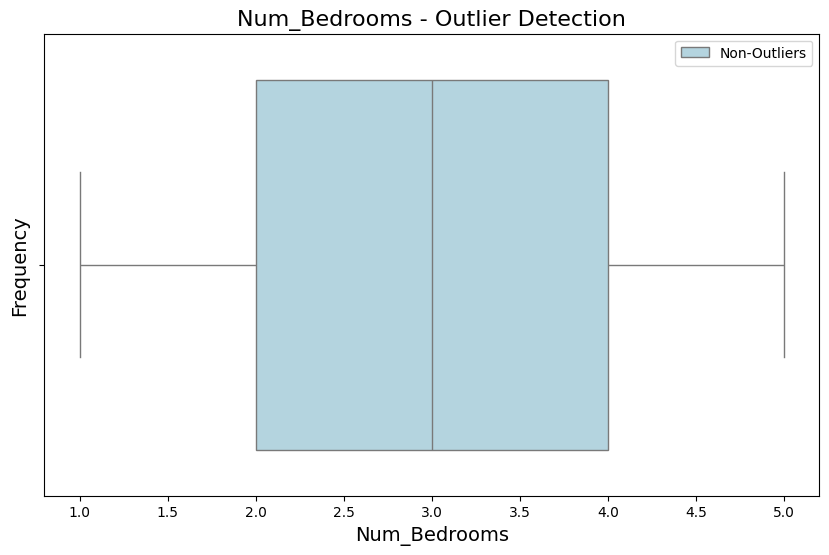

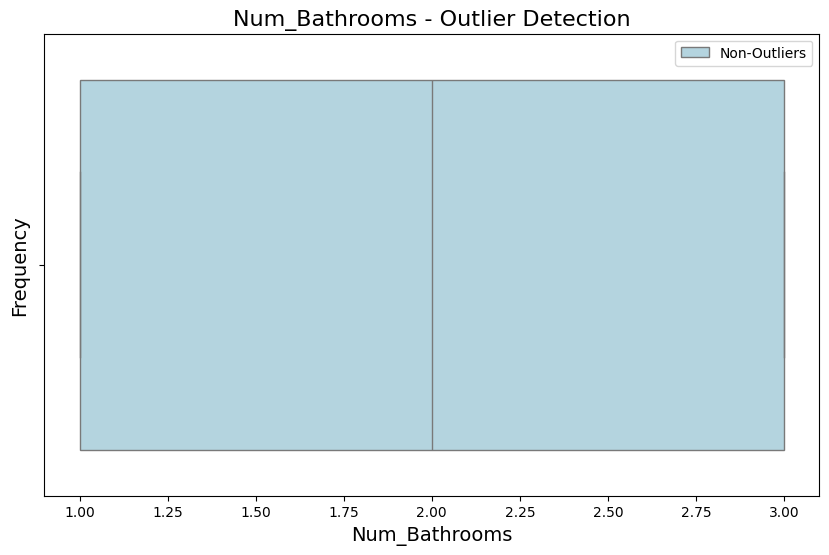

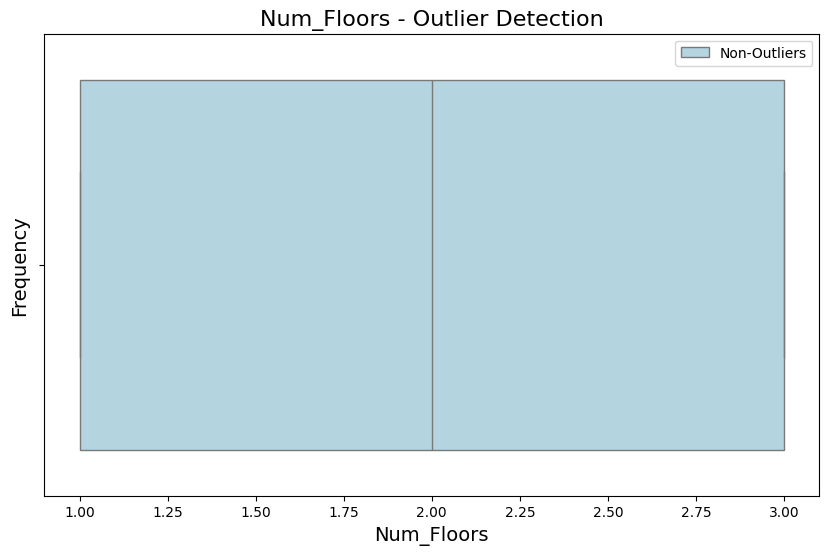

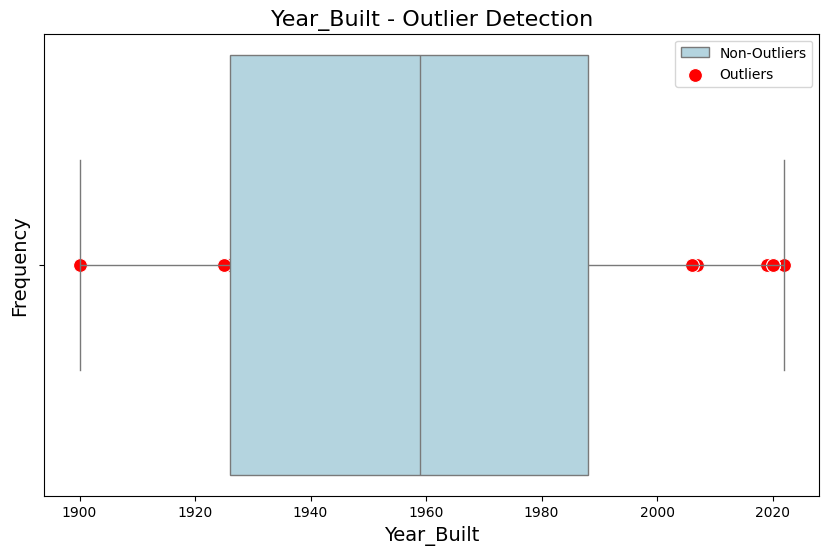

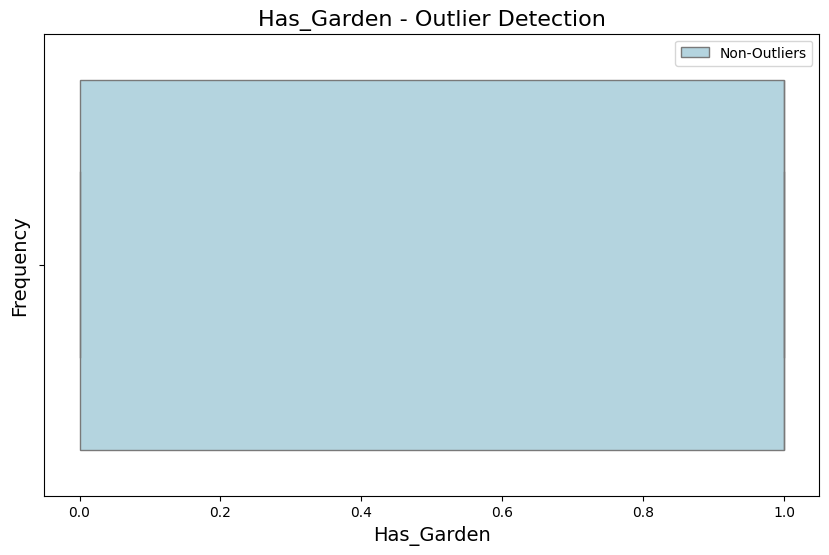

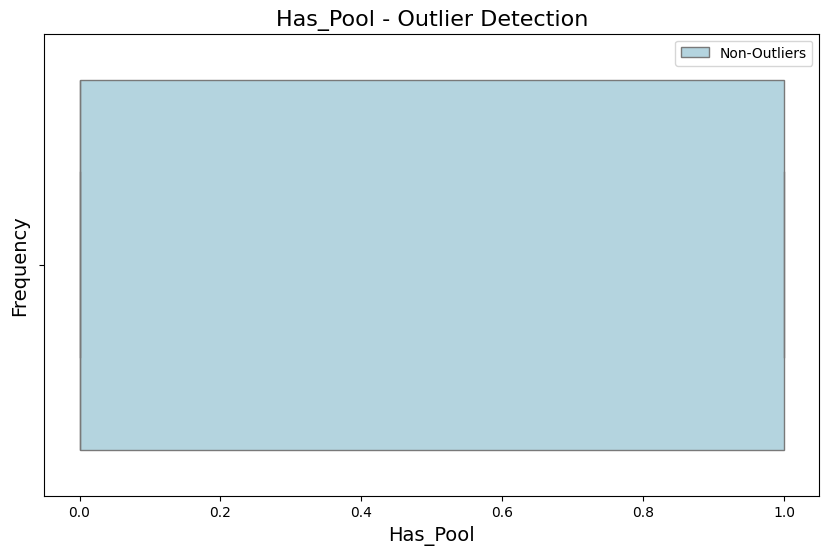

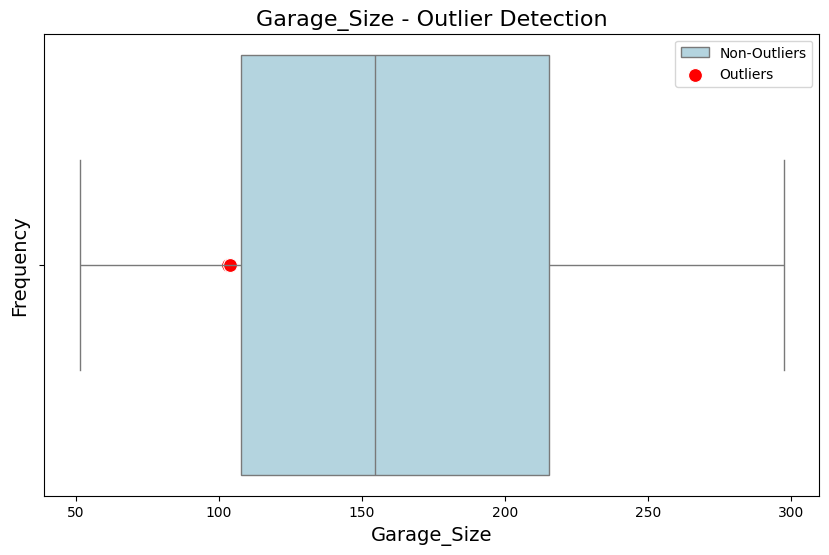

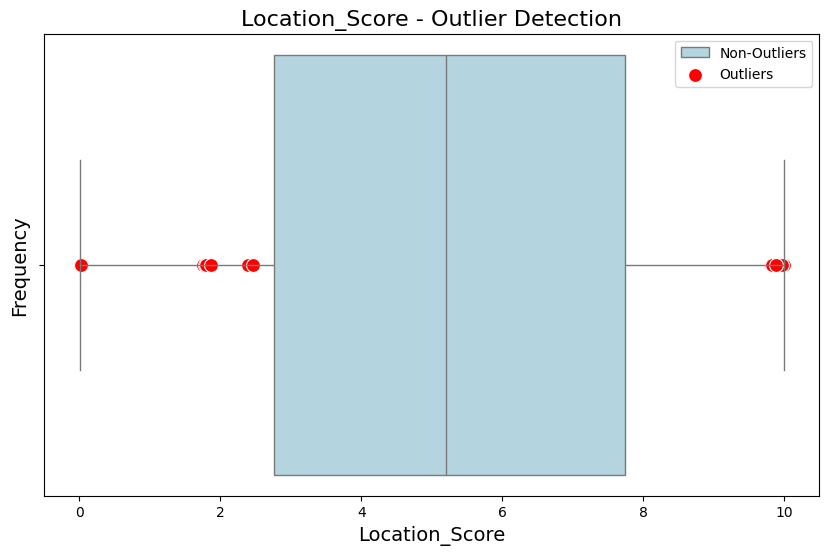

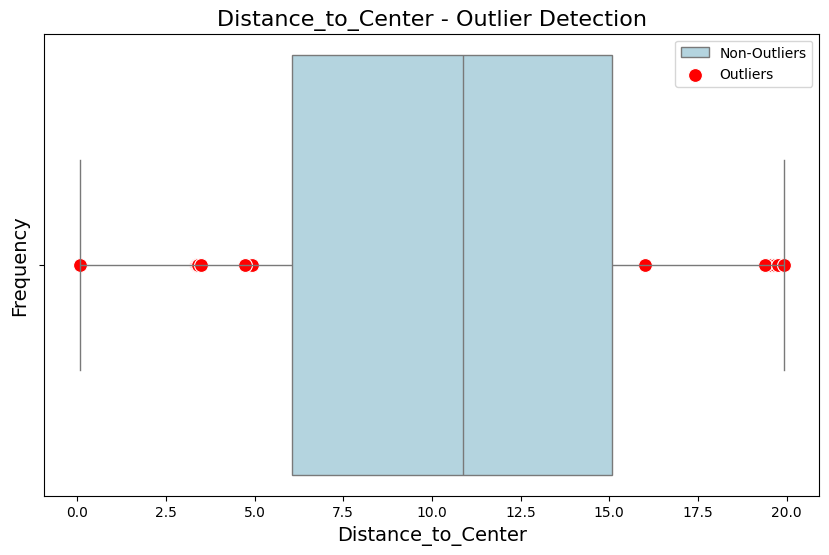

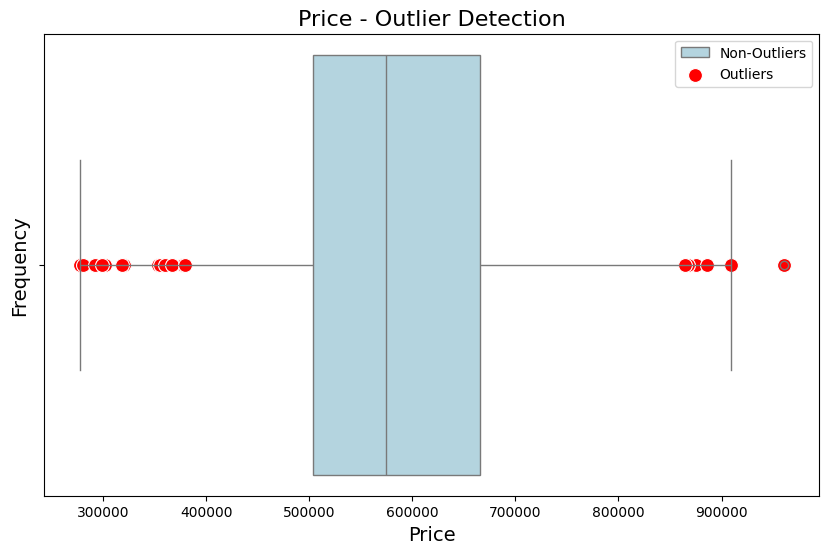

In [20]:
# List of numerical columns in the dataframe, excluding 'ID', LOF columns, and categorical columns
numerical_columns = house_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'ID' and 'LOF_Score' not in col]  # Skip 'ID' and LOF columns

# Loop through each numerical column and plot the boxplot with outliers
for column in numerical_columns:
    # Filter outliers and non-outliers for the current column
    outliers = house_df[house_df[f'Is_Outlier_{column}'] == True]
    non_outliers = house_df[house_df[f'Is_Outlier_{column}'] == False]

    # Set up the plot for this column
    plt.figure(figsize=(10, 6))

    # Plot the non-outliers
    sns.boxplot(x=house_df[column], color='lightblue', label='Non-Outliers')

    # Plot the outliers (overlay on the same plot)
    sns.scatterplot(x=outliers[column], y=[0] * len(outliers), color='red', marker='o', s=100, label='Outliers')

    # Title and labels
    plt.title(f'{column} - Outlier Detection', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()


### Choose a column to check outliers:
In the cell below choose a column by entering a value in the "col" variable

In [21]:
# Get rows where 'Is_Outlier_Year_Built' is True

col = "Price"
outliers_year_built = house_df[house_df[f'Is_Outlier_{col}'] == True]

# Display the rows
outliers_year_built[main_columns]


ID  Square_Feet  Num_Bedrooms  Num_Bathrooms  Num_Floors  Year_Built  \
7      8   419.792100             5              1           3        1973   
40    41   312.153100             1              1           2        1924   
52    53   284.874735             5              2           2        2012   
90    91   139.930700             1              1           2        1920   
102  103   387.500400             1              2           3        1901   
148  149   441.319900             1              1           2        1983   
150  151   322.917000             5              2           3        2019   
171  172   322.917000             2              1           1        1935   
179  180   387.500400             1              3           1        1901   
200  201   452.083800             5              3           2        2000   
209  210   290.625300             1              3           2        1944   
224  225   150.694600             1              2           1        1920   
254  255   495.139400             2              3           1        1912   
291  292   269.097500             3              1           2        1909   
294  295   118.402900             1              2           1        1910   
332  333   419.792100             1              1           1        1961   
356  357   355.208700             2              2           1        1938   
377  378   279.861400             3              1           2        1920   
409  410   290.625300             1              1           2        1928   
434  435   484.375500             1              1           1        1931   
452  453   355.208700             2              3           2        1904   
470  471   505.903300             3              1           2        1904   
473  474   398.264300             5              1           2        2017   
487  488   365.972600             1              3           1        1924   
499  500   296.552686             4              3           1        1988   

     Has_Garden  Has_Pool  Garage_Size  Location_Score  Distance_to_Center  \
7             1         1   266.544036        9.373784           12.692785   
40            1         1    80.509559        9.306068           15.459734   
52            1         1   226.041900        7.608543           13.945508   
90            0         1    79.898561        2.320398            0.906386   
102           0         0   128.588995        0.460567            8.521420   
148           0         0    62.869688        1.438144            9.262294   
150           1         1   277.066471        9.037576           13.094182   
171           1         0    54.146957        7.739062            4.021303   
179           1         1    84.380236        3.918240           14.136757   
200           1         1   210.507912        8.180267           18.332066   
209           0         0    90.202013        5.424710            7.811872   
224           1         0   116.300592        5.600917            9.882953   
254           0         1    92.373187        0.160619            9.097449   
291           1         0    59.337047        3.906821            8.707873   
294           0         1    81.765128        9.349944           17.837862   
332           1         1    53.598372        6.307005           15.611121   
356           1         0    56.627828        1.170660           10.455203   
377           0         1    55.817984        4.980404           18.646455   
409           0         1    72.821669        8.849643            7.530606   
434           0         1    71.026702        5.350255           15.257867   
452           0         0   156.055502        1.118806           15.467621   
470           1         0    53.038619        2.160601            8.622248   
473           1         0   272.785778        6.322166            8.371646   
487           1         0   120.240797        4.145161           18.258620   
499           1         1  

### Perform Imputation on Outliers:

The Year_Built column  outliers are imputed with the mode year and the rest are imputed with the median

In [22]:
# Columns to check for outliers and perform imputation
columns_to_impute = [
    'Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built',
    'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price'
]

# Apply appropriate imputation method based on outlier status
for col in columns_to_impute:
    outlier_col = 'Is_Outlier_' + col

    if outlier_col in house_df.columns:
        # Use Mode for Year_Built, otherwise use Median for other numerical columns
        if col == 'Year_Built':
            imputation_value = house_df[col].mode()[0]  # Mode for Year_Built
        else:
            imputation_value = house_df[col].median()  # Median for other numerical columns

        # Apply the imputation to outlier rows
        house_df.loc[house_df[outlier_col] == True, col] = imputation_value


### Verify the outliers have been cleaned:

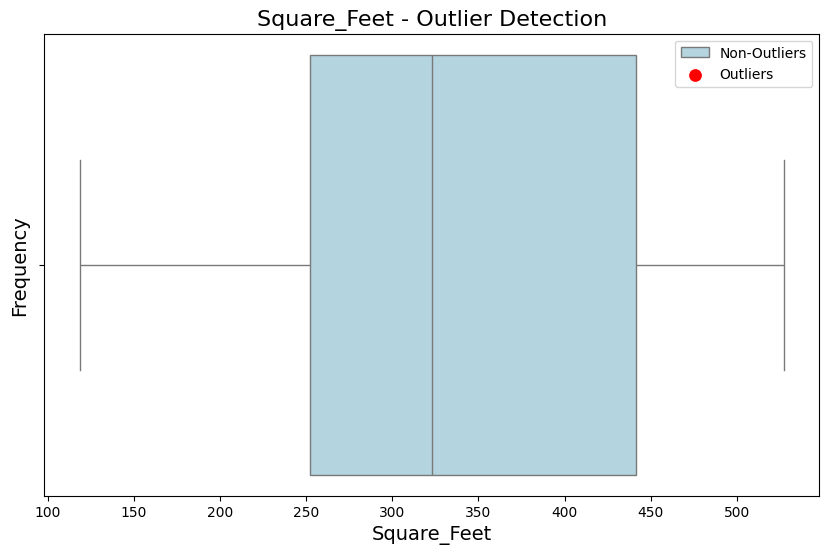

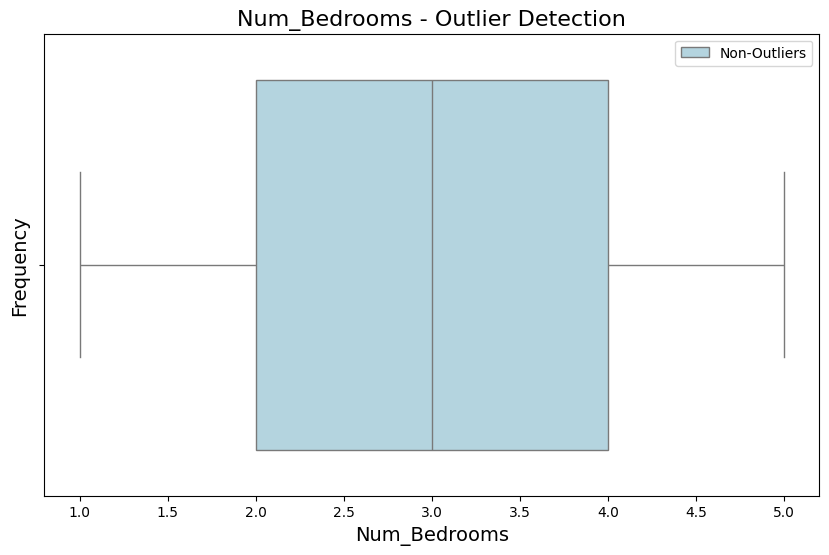

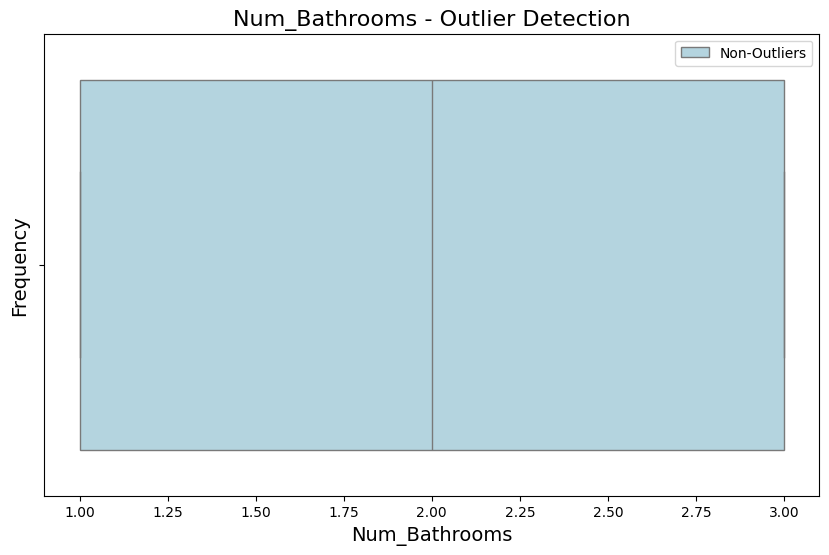

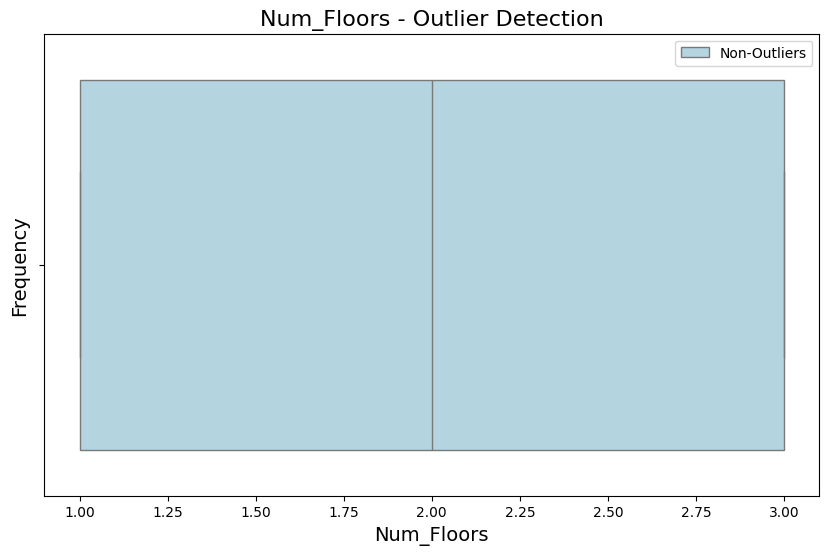

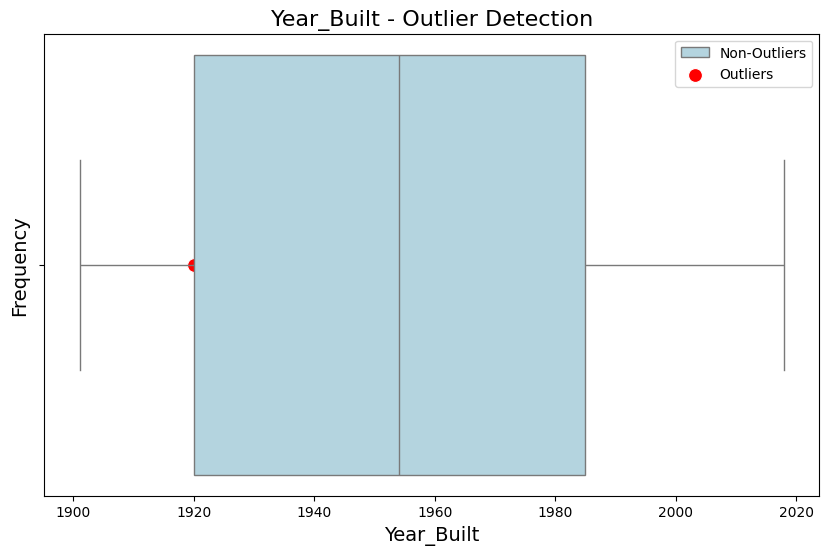

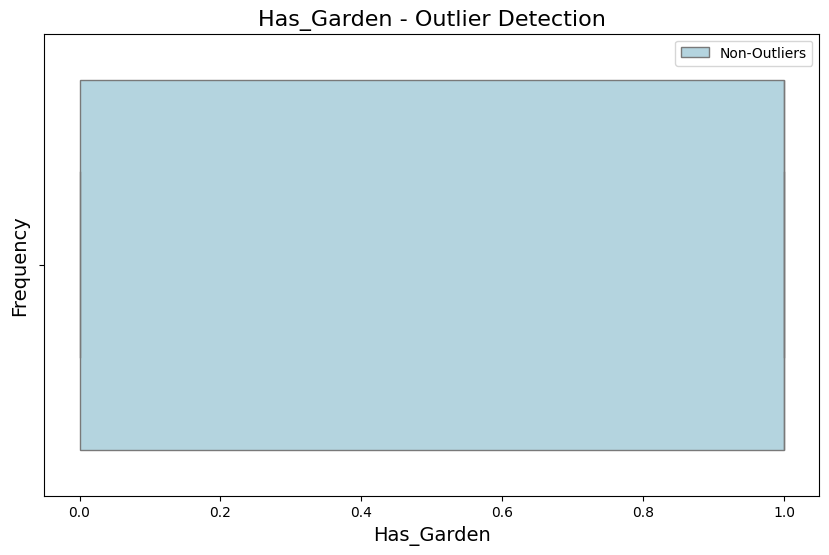

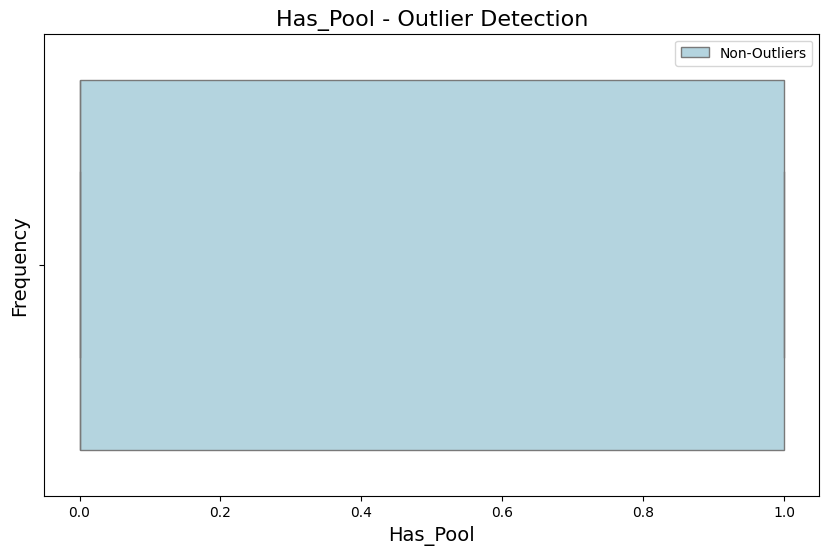

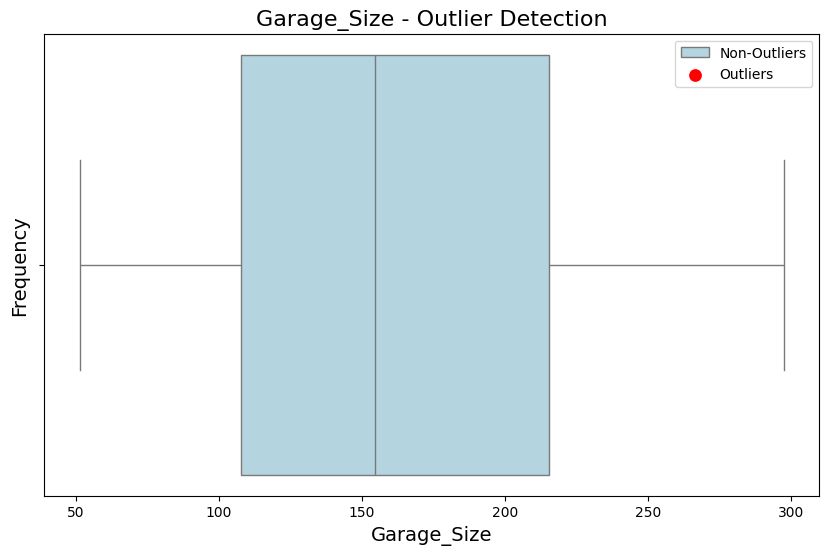

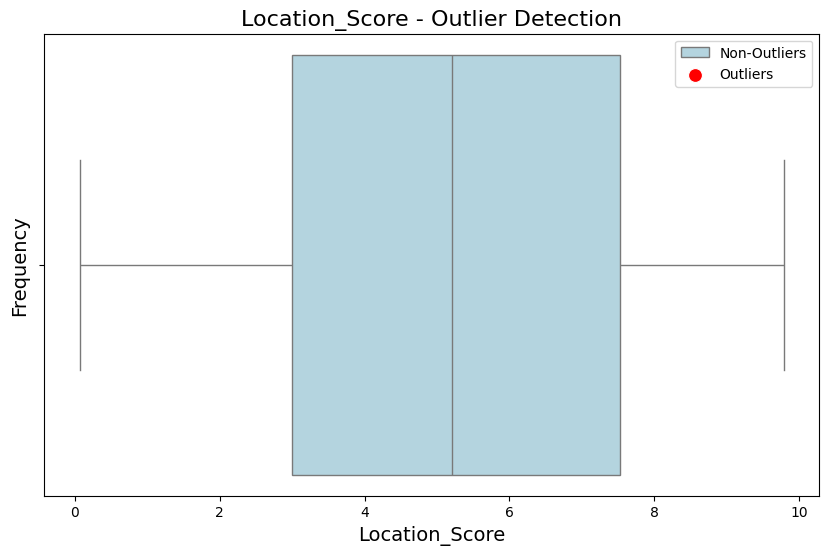

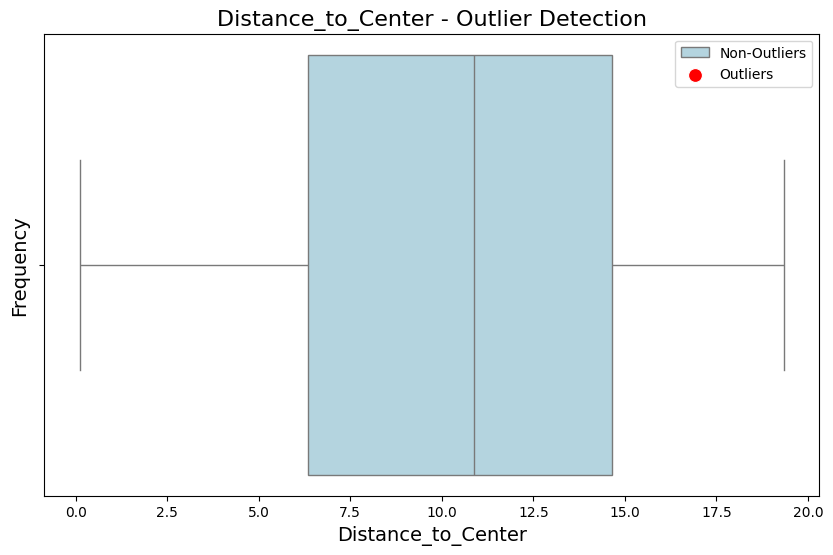

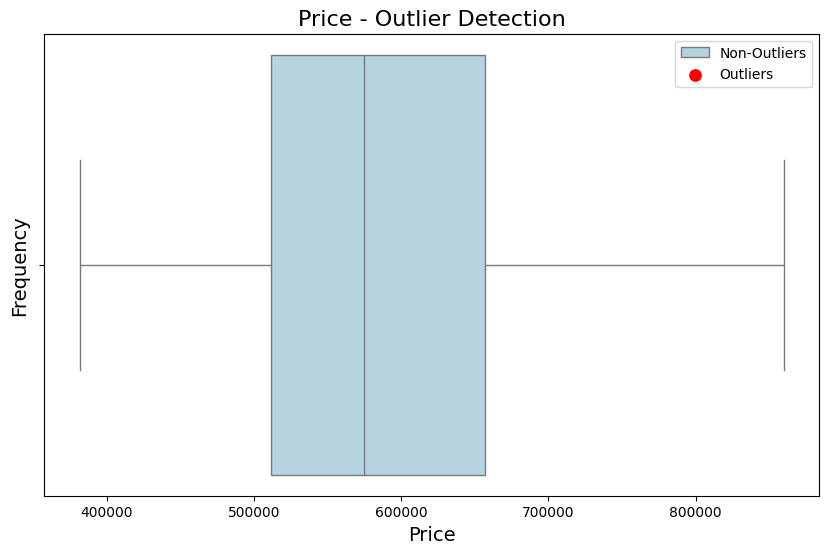

In [23]:
# List of numerical columns in the dataframe, excluding 'ID', LOF columns, and categorical columns
numerical_columns = house_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'ID' and 'LOF_Score' not in col]  # Skip 'ID' and LOF columns

# Loop through each numerical column and plot the boxplot with outliers
for column in numerical_columns:
    # Filter outliers and non-outliers for the current column
    outliers = house_df[house_df[f'Is_Outlier_{column}'] == True]
    non_outliers = house_df[house_df[f'Is_Outlier_{column}'] == False]

    # Set up the plot for this column
    plt.figure(figsize=(10, 6))

    # Plot the non-outliers
    sns.boxplot(x=house_df[column], color='lightblue', label='Non-Outliers')

    # Plot the outliers (overlay on the same plot)
    sns.scatterplot(x=outliers[column], y=[0] * len(outliers), color='red', marker='o', s=100, label='Outliers')

    # Title and labels
    plt.title(f'{column} - Outlier Detection', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 4) Regression
Training a simple regression model to predict the price of houses with different features

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assuming the dataset is called house_df

# Define binary features for prediction
binary_features = ['Has_Garden', 'Has_Pool']

# Define target variable
target = 'Price'

# Define X (features) and y (target)
X = house_df[binary_features]
y = house_df[target]

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Define the scenarios for predictions
scenarios = [
    {'Has_Garden': 0, 'Has_Pool': 0},  # Neither has garden nor pool
    {'Has_Garden': 1, 'Has_Pool': 1},  # Both garden and pool
    {'Has_Garden': 0, 'Has_Pool': 1},  # Only has pool
    {'Has_Garden': 1, 'Has_Pool': 0}   # Only has garden
]

# Make predictions for each scenario
predictions = []
for scenario in scenarios:
    scenario_df = pd.DataFrame([scenario])  # Convert the scenario dictionary into a DataFrame
    predicted_price = model.predict(scenario_df)  # Predict the price
    predictions.append(predicted_price[0])  # Store the result

# Output the predictions for each scenario
for i, prediction in enumerate(predictions):
    print(f"Scenario {i + 1}: Predicted Price = {prediction:.2f}")


Scenario 1: Predicted Price = 572867.90
Scenario 2: Predicted Price = 608520.90
Scenario 3: Predicted Price = 597664.85
Scenario 4: Predicted Price = 583723.95


## Extra Stuff:

In [26]:
# Select features and target variable
X = house_df[['Square_Feet', 'Num_Bedrooms']]
y = house_df['Price']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to training data
model.fit(X_train, y_train)

LinearRegression()

In [213]:
y_pred = model.predict(X_test)

In [214]:
# Calculate Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared Score: {r2:.4f}')

Mean Squared Error: 8509035437.64
R-squared Score: 0.2321


Mean Squared Error: 10770744108.33621
R-squared: 0.02800010964987465


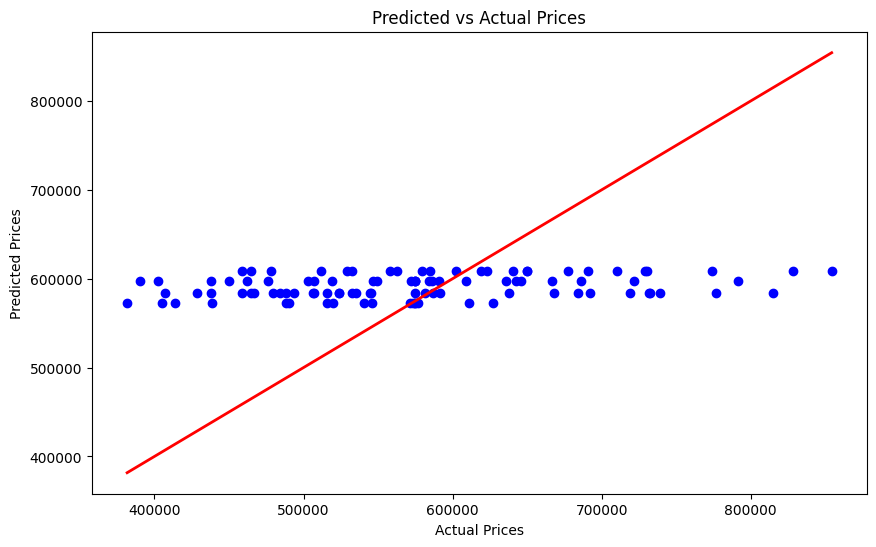

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming the dataset is called house_df

# Define binary features for prediction
binary_features = ['Has_Garden', 'Has_Pool']

# Define target variable
target = 'Price'

# Define X (features) and y (target)
X = house_df[binary_features]
y = house_df[target]

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()


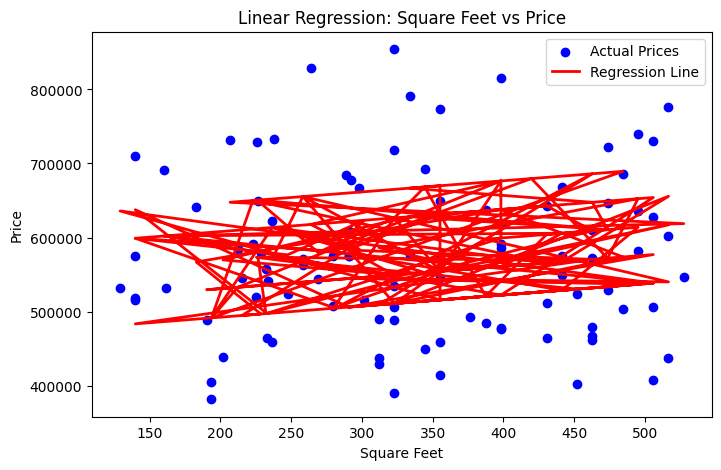

In [215]:
plt.figure(figsize=(8,5))

# Scatter plot of actual data
plt.scatter(X_test['Square_Feet'], y_test, color='blue', label='Actual Prices')

# Regression line
plt.plot(X_test['Square_Feet'], y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel("Square Feet")
plt.ylabel("Price")
plt.title("Linear Regression: Square Feet vs Price")
plt.legend()
plt.show()

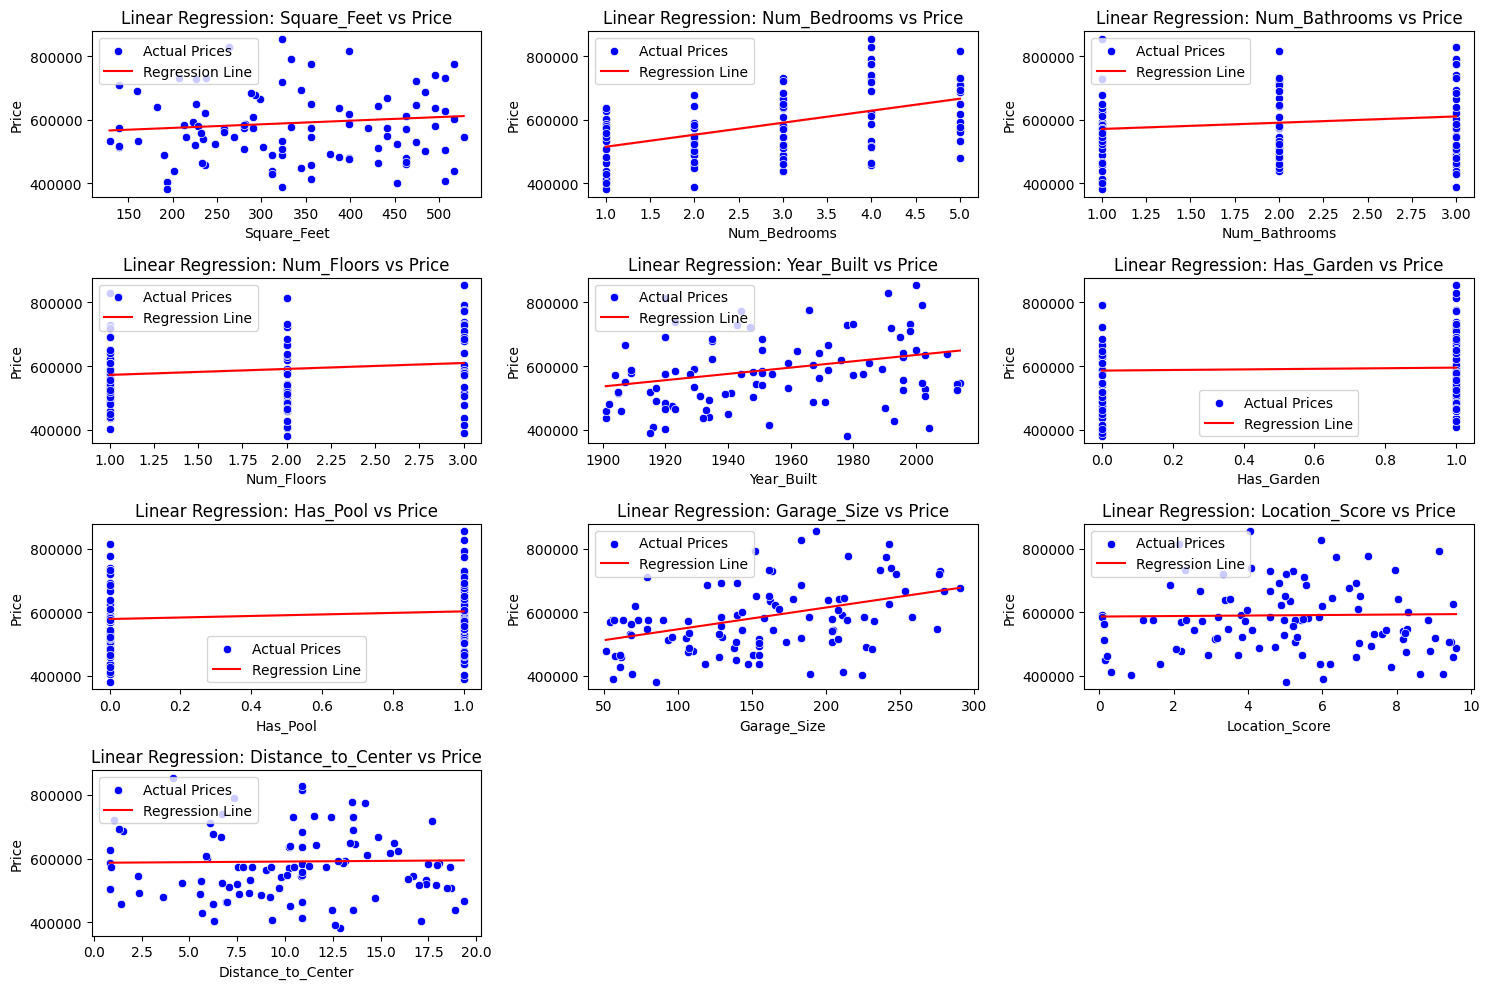

              Feature           MSE  R2_Score
1        Num_Bedrooms  8.493295e+09  0.233527
7         Garage_Size  9.198899e+09  0.169850
4          Year_Built  1.030504e+10  0.070028
3          Num_Floors  1.092104e+10  0.014437
6            Has_Pool  1.100759e+10  0.006626
2       Num_Bathrooms  1.109436e+10 -0.001204
5          Has_Garden  1.116009e+10 -0.007137
8      Location_Score  1.134991e+10 -0.024267
9  Distance_to_Center  1.136358e+10 -0.025500
0         Square_Feet  1.141211e+10 -0.029880


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define numerical columns (excluding 'ID', 'Price', LOF, and Is_Outlier columns)
numerical_columns = [col for col in house_df.columns if house_df[col].dtype in ['int64', 'float64'] 
                     and not (col.startswith('LOF_') or col.startswith('Is_Outlier_')) 
                     and col not in ['ID', 'Price']]

# Store model performance
results = []

# Set up figure for multiple plots
plt.figure(figsize=(15, 10))

# Loop through numerical columns
for i, feature in enumerate(numerical_columns):
    # Define features and target
    X = house_df[[feature]]
    y = house_df['Price']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({'Feature': feature, 'MSE': mse, 'R2_Score': r2})

    # Plot regression line
    rows = int(np.ceil(len(numerical_columns) / 3))  # Auto-adjust rows
    plt.subplot(rows, 3, i+1)

    sns.scatterplot(x=X_test[feature], y=y_test, color='blue', label='Actual Prices')
    sns.lineplot(x=X_test[feature], y=y_pred, color='red', label='Regression Line')

    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(f'Linear Regression: {feature} vs Price')
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

# Convert results into a DataFrame for better readability
results_df = pd.DataFrame(results).sort_values(by="R2_Score", ascending=False)
print(results_df)


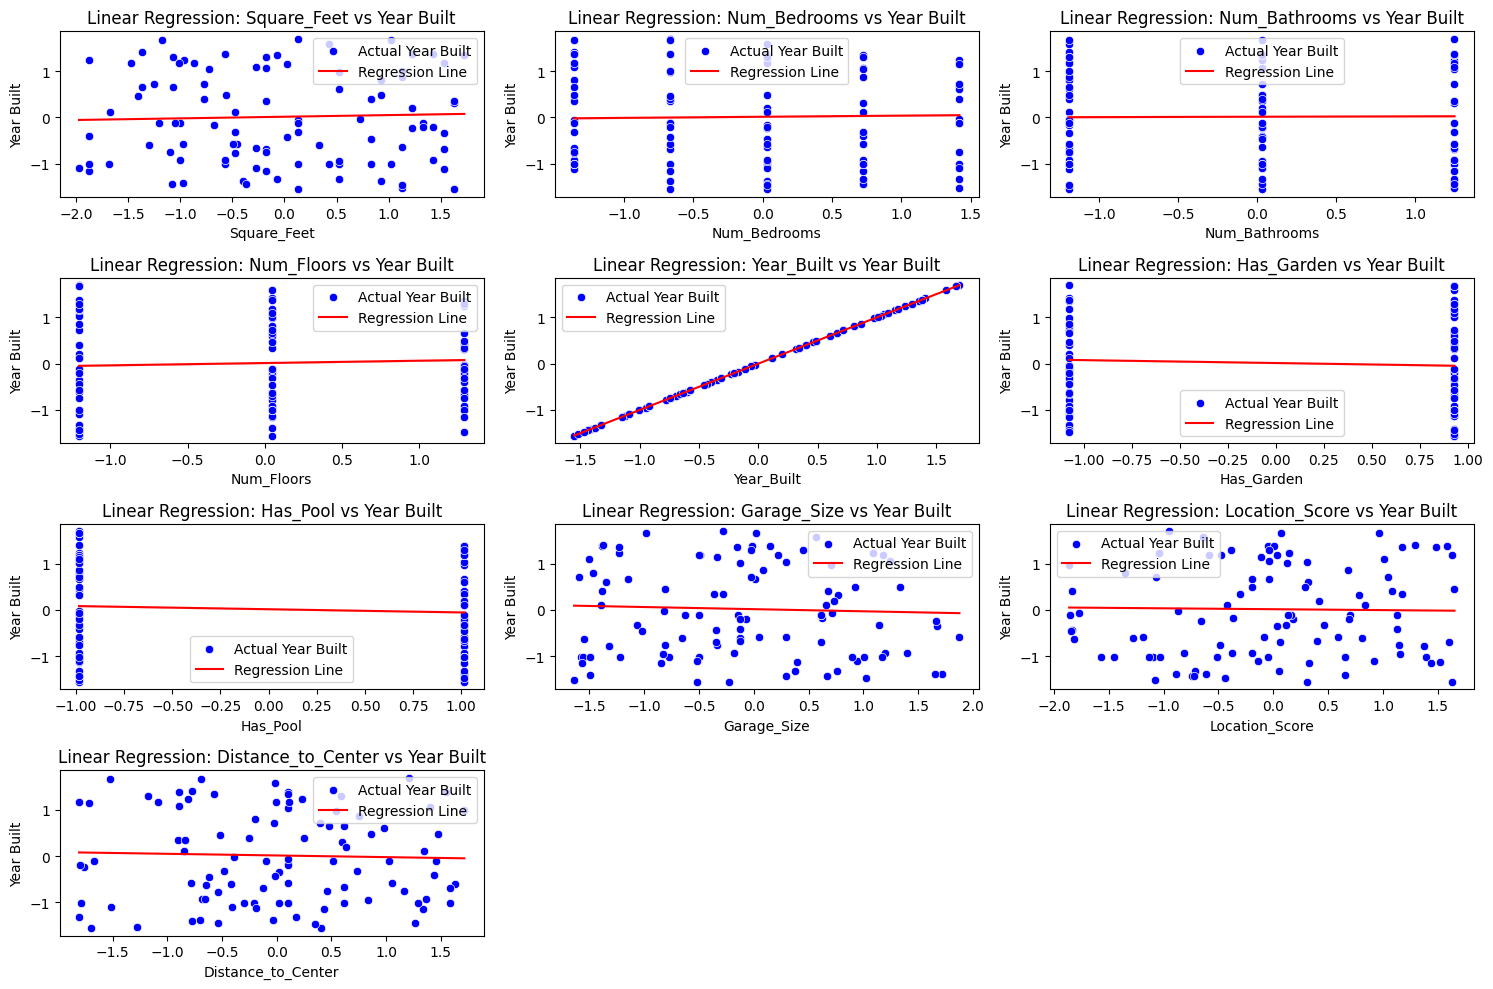

              Feature           MSE  R2_Score
4          Year_Built  4.129495e-32  1.000000
7         Garage_Size  9.386257e-01 -0.002437
6            Has_Pool  9.410359e-01 -0.005010
9  Distance_to_Center  9.423118e-01 -0.006373
2       Num_Bathrooms  9.439423e-01 -0.008114
0         Square_Feet  9.455279e-01 -0.009808
1        Num_Bedrooms  9.456779e-01 -0.009968
8      Location_Score  9.462695e-01 -0.010600
3          Num_Floors  9.474746e-01 -0.011887
5          Has_Garden  9.542508e-01 -0.019124


In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define numerical columns (excluding 'ID', 'Price', LOF, and Is_Outlier columns)
numerical_columns = [col for col in house_df.columns if house_df[col].dtype in ['int64', 'float64'] 
                     and not (col.startswith('LOF_') or col.startswith('Is_Outlier_')) 
                     and col not in ['ID', 'Price']]

# Standardize the features
scaler = StandardScaler()
house_df[numerical_columns] = scaler.fit_transform(house_df[numerical_columns])

# Store model performance
results = []

# Set up figure for multiple plots
plt.figure(figsize=(15, 10))

# Loop through numerical columns
for i, feature in enumerate(numerical_columns):
    # Define features and target
    X = house_df[[feature]]
    y = house_df['Year_Built']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({'Feature': feature, 'MSE': mse, 'R2_Score': r2})

    # Plot regression line
    rows = int(np.ceil(len(numerical_columns) / 3))  # Auto-adjust rows
    plt.subplot(rows, 3, i+1)

    sns.scatterplot(x=X_test[feature], y=y_test, color='blue', label='Actual Year Built')
    sns.lineplot(x=X_test[feature], y=y_pred, color='red', label='Regression Line')

    plt.xlabel(feature)
    plt.ylabel('Year Built')
    plt.title(f'Linear Regression: {feature} vs Year Built')
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

# Convert results into a DataFrame for better readability
results_df = pd.DataFrame(results).sort_values(by="R2_Score", ascending=False)
print(results_df)


# 5) Feature Engineering

## Cost per square foot:

In [29]:
# Assuming house_df is your DataFrame

# Create the 'Cost_Per_Square_Foot' column
house_df['Cost_Per_Square_Foot'] = house_df['Price'] / house_df['Square_Feet']

# Check the first few rows to verify
house_df[['Price', 'Square_Feet', 'Cost_Per_Square_Foot']].head()


Price  Square_Feet  Cost_Per_Square_Foot
0  602134.816747   516.667200           1165.421023
1  591425.135386   398.264300           1485.006654
2  464478.696880   232.998485           1993.483760
3  583105.655996   199.664621           2920.425526
4  619879.142523   365.972600           1693.785662

## Cost Per Floor:

In [30]:
house_df['Price_Per_Floor'] = house_df['Price'] / house_df['Num_Floors']

# Check the first few rows to verify
house_df[['Price', 'Num_Floors', 'Price_Per_Floor']].head()

Price  Num_Floors  Price_Per_Floor
0  602134.816747           3    200711.605582
1  591425.135386           1    591425.135386
2  464478.696880           2    232239.348440
3  583105.655996           2    291552.827998
4  619879.142523           3    206626.380841

## Garage Size Per Square Foot:

In [31]:
house_df['Garage_Size_Per_Square_Foot'] = house_df['Garage_Size'] / house_df['Square_Feet']

# Check the first few rows to verify
house_df[['Price', 'Square_Feet', 'Garage_Size', 'Garage_Size_Per_Square_Foot']].head()

Price  Square_Feet  Garage_Size  Garage_Size_Per_Square_Foot
0  602134.816747   516.667200   143.635030                     0.278003
1  591425.135386   398.264300   287.678577                     0.722331
2  464478.696880   232.998485   150.694600                     0.646762
3  583105.655996   199.664621   182.986300                     0.916468
4  619879.142523   365.972600    89.004660                     0.243200

# 6) Empirical Study

 The empirical study will be performed using R2 validation

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Define features (X) and target (y) - excluding 'Price' as target
X = house_df.drop(columns=['Price'])  # Keep all numerical features
y = house_df['Price']  # Target variable

# Initialize the Linear Regression model
model = LinearRegression()

# Perform 4-fold cross-validation on validation set
r2_scores = cross_val_score(model, X, y, cv=4, scoring='r2')

# Print results
print("R² Scores for each fold:", r2_scores)
print("Average R² Score:", np.mean(r2_scores))


R² Scores for each fold: [0.82948935 0.83345339 0.84170001 0.82979731]
Average R² Score: 0.8336100152195882


# Sources:
Smallest Possible House Size: https://www.greatlakestinyhome.com/worlds-smallest-house/#:~:text=Keret%20House%2C%20Poland&text=It%20boasts%20a%20world%20record,story%20on%20the%20first%20floor.

Oldest built home: https://geojango.com/blogs/explore-your-world/oldest-homes-america?srsltid=AfmBOoq0J_96cQgna1C_MJVIoC61INx0zlf6BAcT8YgHT8LzfNNKZdNC

Minumum Garage Size: https://shedsunlimited.net/blog/how-large-is-a-one-car-garage/?srsltid=AfmBOoq7cjf-SXORwozvt1vRW4ow4GMjwQg8tTLz0ldzLrky1VLNK3zc